# Mid-semester assignment
**Student name**: Suyash Lal <br>
**Student ID**: 210477

### Library imports

In [43]:
# Guitar Chord Detection - Building on Note Detection
# Import required libraries
import subprocess
import os
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import tkinter as tk
from tkinter import filedialog
from collections import Counter

# Set up matplotlib for inline display
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## Preprocessing

### Override play() function
This function overrides pydub’s default play() method to stream audio directly from memory instead of creating temporary files. It avoids **Windows permission errors** by using *BytesIO* to store the audio in RAM and pipes it to ffplay for playback. This allows you to use play(wav) seamlessly without temporary files, while maintaining compatibility with pydub’s standard workflow. This makes it possible to work on any machine, regardless of permissions.

In [44]:
# Override play function to prevent temp file issues
def _play_with_ffplay_memory_fix(audio_segment):
    buffer = BytesIO()
    audio_segment.export(buffer, format="wav")
    buffer.seek(0)
    
    ffplay_cmd = [
        "ffplay",
        "-nodisp",
        "-autoexit",
        "-hide_banner",
        "-i", "pipe:0"
    ]
    
    proc = subprocess.Popen(
        ffplay_cmd,
        stdin=subprocess.PIPE,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    proc.communicate(input=buffer.read())
    buffer.close()

# Replace pydub's internal ffplay handler
import pydub.playback
pydub.playback._play_with_ffplay = _play_with_ffplay_memory_fix

#### Load the path of the file

File: Fm_4thString.wav
Duration: 6.13 seconds
Sample Rate: 44100 Hz
Channels: 1 (mono)
Attempting to play audio...
Playback completed successfully.


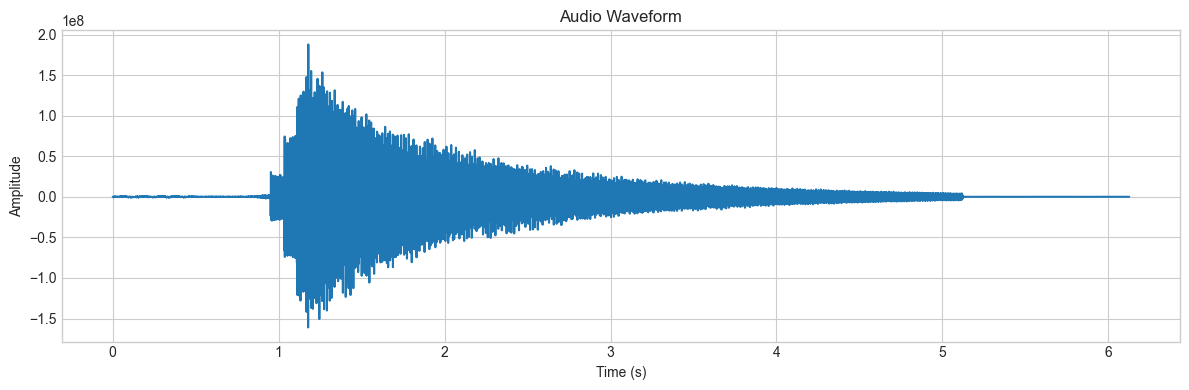

In [45]:
# Open file dialog to select chord audio
root = tk.Tk()
root.withdraw()  # Hide the main window

file_path = filedialog.askopenfilename(
    title="Select a WAV file containing a guitar chord",
    filetypes=[("WAV files", "*.wav")]
)

if file_path:
    try:
        # Load and preprocess audio
        file = AudioSegment.from_file(file_path, format="wav")
        # Convert to mono
        file = file.set_channels(1)
        # High-pass filter
        file = file.high_pass_filter(80)
        
        # Convert to numpy array
        samples = np.array(file.get_array_of_samples())
        sample_rate = file.frame_rate
        
        # Display basic info
        duration = len(file) / 1000.0  # in seconds
        print(f"File: {os.path.basename(file_path)}")
        print(f"Duration: {duration:.2f} seconds")
        print(f"Sample Rate: {sample_rate} Hz")
        print(f"Channels: 1 (mono)")
        
        # Try playing the file with explicit diagnostic output
        print("Attempting to play audio...")
        try:
            play(file)
            print("Playback completed successfully.")
        except Exception as e:
            print(f"Error using play(): {e}")
            print("Trying alternative playback method...")
            display(Audio(data=samples, rate=sample_rate))
        
        # Plot waveform
        plt.figure(figsize=(12, 4))
        time = np.linspace(0, len(samples) / sample_rate, len(samples))
        plt.plot(time, samples)
        plt.title("Audio Waveform")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error loading or processing file: {e}")
else:
    print("No file selected.")

#### Data Exploration

In [46]:
# check frame rate
print(file.frame_rate)

# check max amplitude
print(file.max)

# To know about channels of file (1 = mono, 2 = stereo)
print(file.channels)

44100
187717791
1


Convert stereo audio to mono (easier to process and analyze for machine learning, pitch detection, and feature extraction)

In [47]:
file = file.set_channels(1)
print(file.channels)

1


## Onset Detection

Spectral Flux calculation (identify sudden changes in the signal)

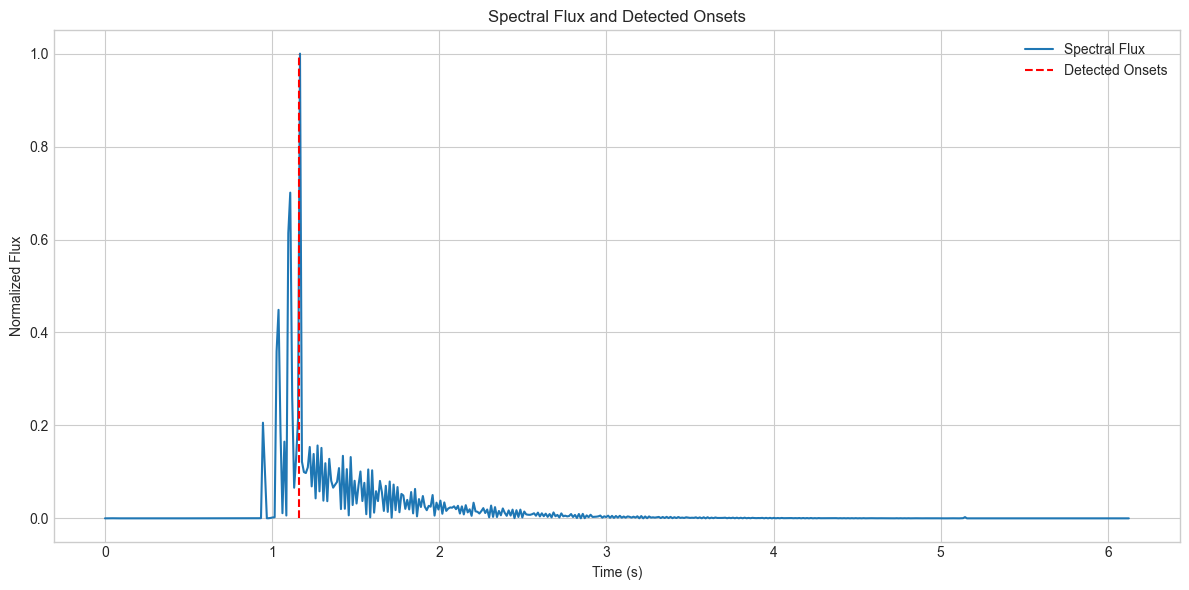

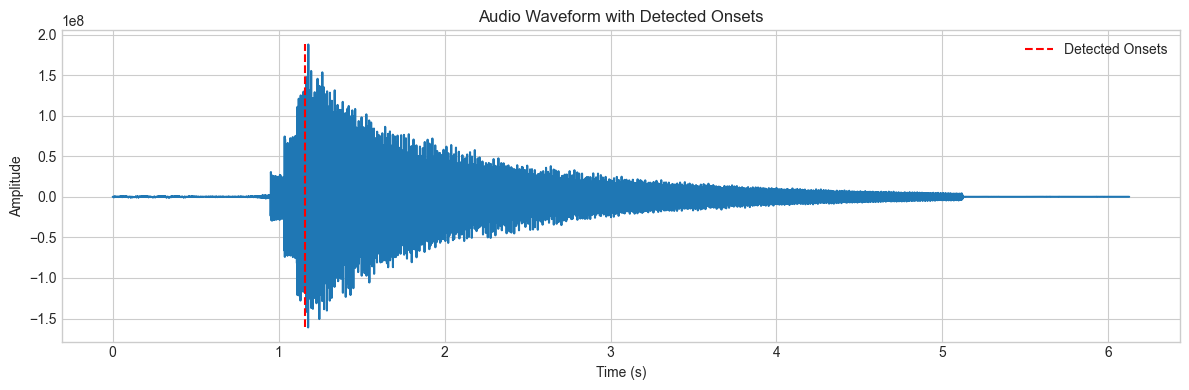

Detected 1 onsets at: 1.16s


In [48]:
def compute_spectral_flux(samples, sample_rate, frame_size=1024, hop_size=512):
    """Compute spectral flux to detect note onsets."""
    # Split audio into frames
    num_frames = int((len(samples) - frame_size) / hop_size) + 1
    frames = np.array([samples[i*hop_size : i*hop_size + frame_size] 
                      for i in range(num_frames)])
    
    # Apply Hann window to reduce spectral leakage
    window = np.hanning(frame_size)
    windowed_frames = frames * window
    
    # Compute FFT magnitudes
    fft_mags = np.abs(np.fft.rfft(windowed_frames, axis=1))
    
    # Calculate spectral flux
    flux = np.sum(np.diff(fft_mags, axis=0)**2, axis=1)
    flux = np.concatenate([np.zeros(1), flux])  # Pad to match frame count
    
    # Normalize flux
    flux = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
    
    return flux, num_frames

def detect_onsets(flux, sample_rate, hop_size=512, threshold=0.3, distance=15):
    """Detect onsets using peak picking on spectral flux."""
    peaks, _ = find_peaks(flux, height=threshold, distance=distance)
    onset_times = peaks * hop_size / sample_rate
    return onset_times, peaks

# Compute spectral flux
flux, num_frames = compute_spectral_flux(samples, sample_rate)

# Detect onsets
onset_times, onset_peaks = detect_onsets(flux, sample_rate, threshold=0.3, distance=15)

# Visualize flux and onsets
plt.figure(figsize=(12, 6))

# Plot the spectral flux
frame_times = np.linspace(0, len(samples) / sample_rate, len(flux))
plt.plot(frame_times, flux, label='Spectral Flux')

# Plot detected onsets
plt.vlines(onset_times, 0, 1, color='r', linestyle='--', label='Detected Onsets')
plt.title("Spectral Flux and Detected Onsets")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()
plt.show()

# Plot waveform with onsets
plt.figure(figsize=(12, 4))
plt.plot(time, samples)
plt.vlines(onset_times, min(samples), max(samples), color='r', linestyle='--', label='Detected Onsets')
plt.title("Audio Waveform with Detected Onsets")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Detected {len(onset_times)} onsets at: {', '.join([f'{t:.2f}s' for t in onset_times])}")

## Audio Segmentation and Export

Exported: chord_processed_files\chord_segment_1.wav

Created and exported 1 chord segments for analysis


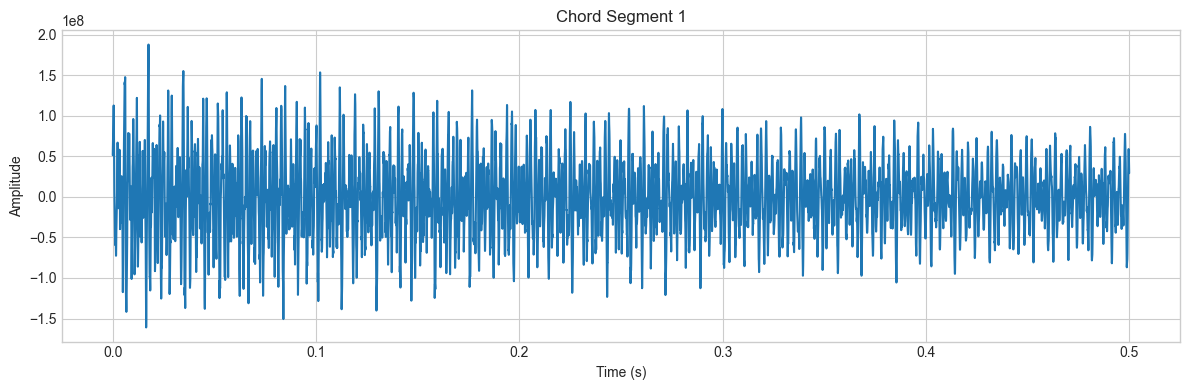

Playing segment 1...


In [49]:
def segment_chord_audio(file, onset_times, segment_duration=0.5):
    """Segment audio file focusing on chord sections."""
    chord_segments = []
    samples = np.array(file.get_array_of_samples())
    
    for onset in onset_times:
        # Convert time to samples
        start_idx = int(onset * file.frame_rate)
        end_idx = start_idx + int(segment_duration * file.frame_rate)
        
        # Ensure we don't exceed audio length
        end_idx = min(end_idx, len(samples))
        
        if start_idx < end_idx:
            # Get the chord section
            chord_samples = samples[start_idx:end_idx]
            
            # Create AudioSegment from chord section
            chord_audio = AudioSegment(
                chord_samples.tobytes(),
                frame_rate=file.frame_rate,
                sample_width=file.sample_width,
                channels=1
            )
            
            chord_segments.append(chord_audio)
    
    return chord_segments

# If no onsets detected, use the whole file
if len(onset_times) == 0:
    print("No clear onsets detected, analyzing entire audio...")
    
    # Create a segment from the full audio (but trim the first 100ms to avoid initial transients)
    start_sample = int(0.1 * sample_rate)
    if len(samples) <= start_sample:
        segment_samples = samples
    else:
        segment_samples = samples[start_sample:]
    
    chord_segment = AudioSegment(
        segment_samples.tobytes(),
        frame_rate=file.frame_rate,
        sample_width=file.sample_width,
        channels=1
    )
    
    chord_segments = [chord_segment]
else:
    # Segment audio at detected onsets
    chord_segments = segment_chord_audio(file, onset_times)

# Create output directory
output_dir = "chord_processed_files"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Export each chord segment
for idx, segment in enumerate(chord_segments):
    output_file = os.path.join(output_dir, f"chord_segment_{idx+1}.wav")
    segment.export(output_file, format="wav")
    print(f"Exported: {output_file}")

# Display number of segments
print(f"\nCreated and exported {len(chord_segments)} chord segments for analysis")

# Visualize the segmented chords
plt.figure(figsize=(12, 4 * min(len(chord_segments), 5)))  # Limit to 5 subplots max

for i, segment in enumerate(chord_segments[:5]):  # Show at most 5 segments
    segment_samples = np.array(segment.get_array_of_samples())
    segment_time = np.linspace(0, len(segment_samples) / segment.frame_rate, len(segment_samples))
    
    plt.subplot(min(len(chord_segments), 5), 1, i+1)
    plt.plot(segment_time, segment_samples)
    plt.title(f"Chord Segment {i+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# Play each segment
for i, segment in enumerate(chord_segments):
    print(f"Playing segment {i+1}...")
    try:
        play(segment)
    except Exception as e:
        print(f"Error playing segment: {e}")
        segment_samples = np.array(segment.get_array_of_samples())
        display(Audio(data=segment_samples, rate=segment.frame_rate))

## Frequency analysis
Fast Fourier Transform (FFT) usage

In [50]:
def analyze_chord_frequencies(chord_segment, min_freq=80, max_freq=1200, peak_height_ratio=0.15):
    """Analyze frequency content of a chord."""
    samples = np.array(chord_segment.get_array_of_samples())
    sample_rate = chord_segment.frame_rate
    
    # Use a longer window for better low-frequency resolution
    n_samples = len(samples)
    n_padded = 2**int(np.ceil(np.log2(n_samples))) * 8  # Increased padding
    
    # Apply Hanning window
    window = np.hanning(n_samples)
    windowed_samples = samples * window
    
    # Compute FFT with zero-padding
    fft = np.fft.fft(windowed_samples, n_padded)
    frequencies = np.fft.fftfreq(n_padded, 1/sample_rate)
    
    # Get positive frequencies only
    positive_mask = frequencies > 0
    frequencies = frequencies[positive_mask]
    magnitude_spectrum = np.abs(fft)[positive_mask]
    
    # Limit to relevant frequency range for guitar
    mask = (frequencies >= min_freq) & (frequencies <= max_freq)
    frequencies = frequencies[mask]
    magnitude_spectrum = magnitude_spectrum[mask]
    
    # Find peaks in the spectrum
    peaks, _ = find_peaks(magnitude_spectrum, 
                         height=max(magnitude_spectrum)*peak_height_ratio, 
                         distance=20)
    peak_frequencies = frequencies[peaks]
    peak_magnitudes = magnitude_spectrum[peaks]
    
    # Sort peaks by magnitude
    sort_idx = np.argsort(peak_magnitudes)[::-1]
    peak_frequencies = peak_frequencies[sort_idx]
    peak_magnitudes = peak_magnitudes[sort_idx]
    
    return peak_frequencies, peak_magnitudes, frequencies, magnitude_spectrum

#### Visualize the graphs

In [51]:
def visualize_fft_analysis_raw(chord_segment, peak_height_ratio=0.15):
    """
    Visualize the FFT analysis process for a chord segment, showing
    frequency spectrum and detected peaks without converting to notes.
    """
    # Step 1: Perform the frequency analysis
    peak_freqs, peak_mags, all_freqs, spectrum = analyze_chord_frequencies(
        chord_segment, peak_height_ratio=peak_height_ratio
    )
    
    # Step 2: Create the plot
    plt.figure(figsize=(14, 8))
    
    # Main spectrum
    plt.subplot(2, 1, 1)
    plt.plot(all_freqs, spectrum, 'b-', label='Magnitude Spectrum')
    
    # Mark the threshold used for peak detection
    threshold = max(spectrum) * peak_height_ratio
    plt.axhline(y=threshold, color='g', linestyle='--', 
                label=f'Detection Threshold ({peak_height_ratio:.2f} × max)')
    
    # Mark peak frequencies
    colors = plt.cm.rainbow(np.linspace(0, 1, len(peak_freqs[:8])))
    for i, (freq, mag, color) in enumerate(zip(peak_freqs[:8], peak_mags[:8], colors)):
        plt.plot(freq, mag, 'o', color=color, markersize=8)
        plt.vlines(x=freq, ymin=0, ymax=mag, color=color, linestyle='-', alpha=0.5)
        
    plt.title('Frequency Spectrum with Detected Peaks')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(80, 1000)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Zoomed in view of peaks
    plt.subplot(2, 1, 2)
    for i, (freq, mag, color) in enumerate(zip(peak_freqs[:8], peak_mags[:8], colors)):
        plt.plot(freq, mag, 'o', color=color, markersize=10, 
                 label=f"Peak {i+1}: {freq:.1f} Hz")
        plt.vlines(x=freq, ymin=0, ymax=mag, color=color, linestyle='-', alpha=0.7)
        plt.annotate(f"{freq:.1f} Hz", xy=(freq, mag), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontsize=12, 
                    bbox=dict(boxstyle='round,pad=0.3', fc=color, alpha=0.3))
    
    plt.title('Top 8 Detected Frequency Peaks')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(min(peak_freqs[:8])*0.9 if len(peak_freqs) > 0 else 80, 
             max(peak_freqs[:8])*1.1 if len(peak_freqs) > 0 else 1000)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print detected frequencies
    print("Detected Frequency Peaks:")
    print("-" * 40)
    print(f"{'Peak #':<6} {'Frequency (Hz)':<15} {'Magnitude':<15} {'Relative Strength':<15}")
    print("-" * 40)
    
    max_mag = max(peak_mags[:8]) if len(peak_mags) > 0 else 1
    for i, (freq, mag) in enumerate(zip(peak_freqs[:8], peak_mags[:8])):
        relative = mag / max_mag * 100
        print(f"{i+1:<6} {freq:<15.1f} {mag:<15.1f} {relative:<15.1f}%")
        
    return peak_freqs, peak_mags

Visualizing FFT analysis for first detected chord segment...


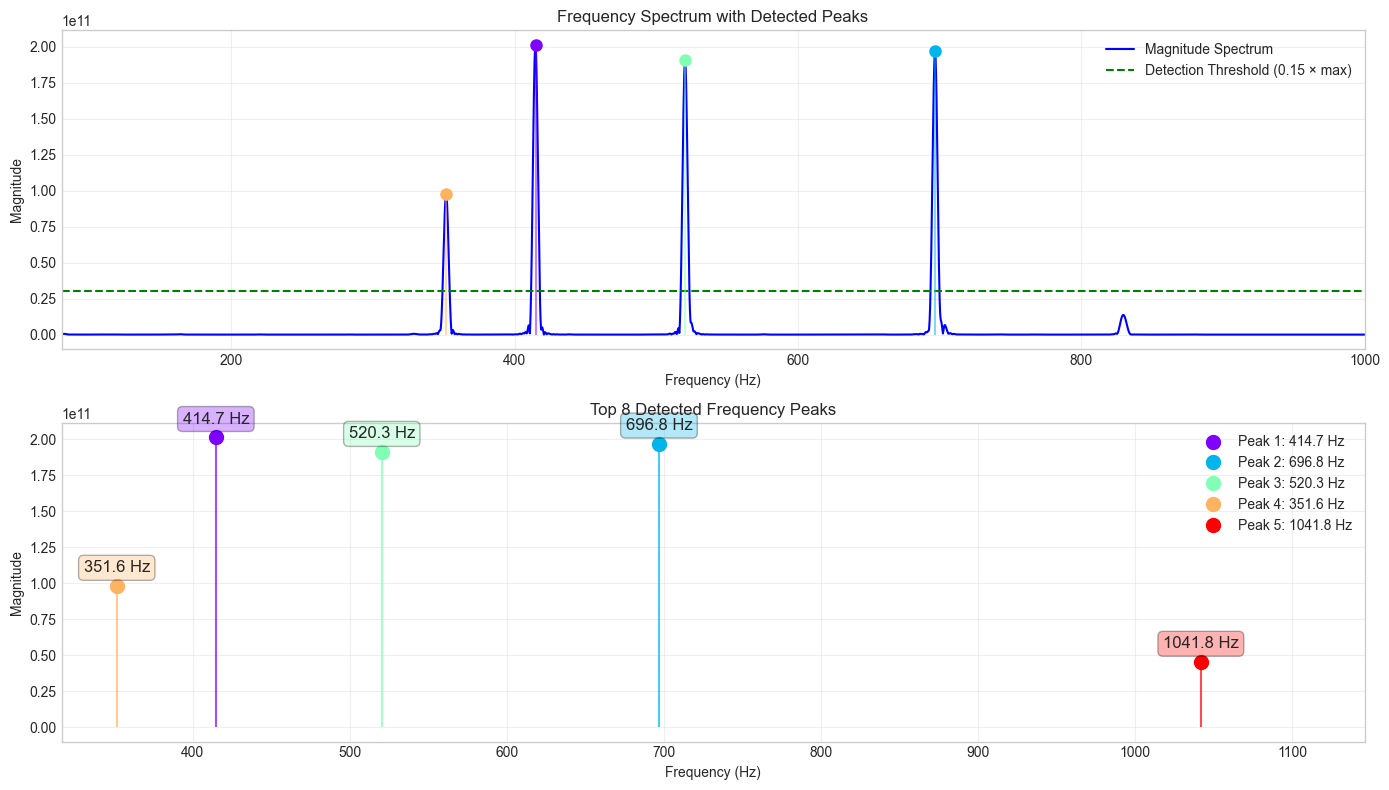

Detected Frequency Peaks:
----------------------------------------
Peak # Frequency (Hz)  Magnitude       Relative Strength
----------------------------------------
1      414.7           201353823575.2  100.0          %
2      696.8           196785074797.8  97.7           %
3      520.3           190987129657.2  94.9           %
4      351.6           97912721467.1   48.6           %
5      1041.8          45114279891.9   22.4           %


In [52]:
# Visualize the FFT analysis for the first chord segment
if len(chord_segments) > 0:
    print("Visualizing FFT analysis for first detected chord segment...")
    peak_freqs, peak_mags = visualize_fft_analysis_raw(chord_segments[0])

## Note and Chord Detection Functions

In [53]:
def frequency_to_note(frequency):
    """Convert a frequency to the closest musical note."""
    # All notes in standard western tuning
    # The reference frequency is A4 = 440 Hz
    A4 = 440.0
    C0 = A4 * 2**(-4.75)  # C0 is 4.75 octaves below A4
    
    # Calculate how many half steps the frequency is away from C0
    h = 12 * np.log2(frequency / C0)
    
    # Round to the nearest half step
    half_step = round(h)
    
    # Get the note index (0-11) and octave
    note_idx = half_step % 12
    octave = half_step // 12
    
    # Note names
    note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    note = note_names[note_idx]
    
    # Return note name without octave for chord identification
    return note

def identify_chord(notes):
    """
    Identify the chord based on detected notes using the 1-3-5 pattern.
    Returns chord name, chord type, and detailed analysis.
    """
    # Count occurrences of each note
    note_counts = Counter(notes)
    unique_notes = list(note_counts.keys())
    
    # Need at least 2 unique notes to form a chord
    if len(unique_notes) < 2:
        return "Not a chord", "unknown", {"error": "Not enough unique notes"}
    
    # Major and minor chord definitions based on scale degrees
    chord_templates = {
        'major': [0, 4, 7],  # Root (1), Major 3rd (3), Perfect 5th (5)
        'minor': [0, 3, 7],  # Root (1), Minor 3rd (3), Perfect 5th (5)
    }
    
    best_match = None
    best_score = 0
    best_chord_type = None
    best_analysis = {}
    
    # Try each note as potential root
    for root in unique_notes:
        # Get note indices (C=0, C#=1, ..., B=11)
        note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
        root_idx = note_names.index(root)
        
        # Calculate normalized positions of all detected notes relative to root
        note_positions = []
        for note in unique_notes:
            note_idx = note_names.index(note)
            # Calculate semitone distance from root (wrapped to single octave)
            position = (note_idx - root_idx) % 12
            note_positions.append(position)
        
        # Check against each chord template
        for chord_type, template in chord_templates.items():
            # Count matching notes
            matching_notes = sum(1 for pos in note_positions if pos in template)
            # Count template notes present
            template_coverage = sum(1 for pos in template if pos in note_positions)
            
            # Score based on matching and coverage
            score = matching_notes + template_coverage
            
            # Map detected notes to chord functions (1, 3, 5)
            chord_tones = {}
            if 0 in note_positions:  # Root/1
                chord_tones[1] = root  # The root note is the 1st degree
            
            if chord_type == 'major' and 4 in note_positions:  # Major 3rd
                third_idx = (root_idx + 4) % 12
                chord_tones[3] = note_names[third_idx]
            elif chord_type == 'minor' and 3 in note_positions:  # Minor 3rd
                third_idx = (root_idx + 3) % 12
                chord_tones[3] = note_names[third_idx]
                
            if 7 in note_positions:  # Perfect 5th
                fifth_idx = (root_idx + 7) % 12
                chord_tones[5] = note_names[fifth_idx]
            
            analysis = {
                "root": root,
                "chord_type": chord_type,
                "score": score,
                "matching_notes": matching_notes,
                "template_coverage": template_coverage,
                "chord_tones": chord_tones,
                "note_positions": note_positions,
                "template": template
            }
            
            if score > best_score:
                best_score = score
                best_chord_type = chord_type
                if chord_type == 'major':
                    best_match = f"{root}"  # Major chord is just the root name
                else:
                    best_match = f"{root}m"  # Minor chord has 'm' suffix
                best_analysis = analysis
    
    return best_match, best_chord_type, best_analysis

## Chord Segment Analysis

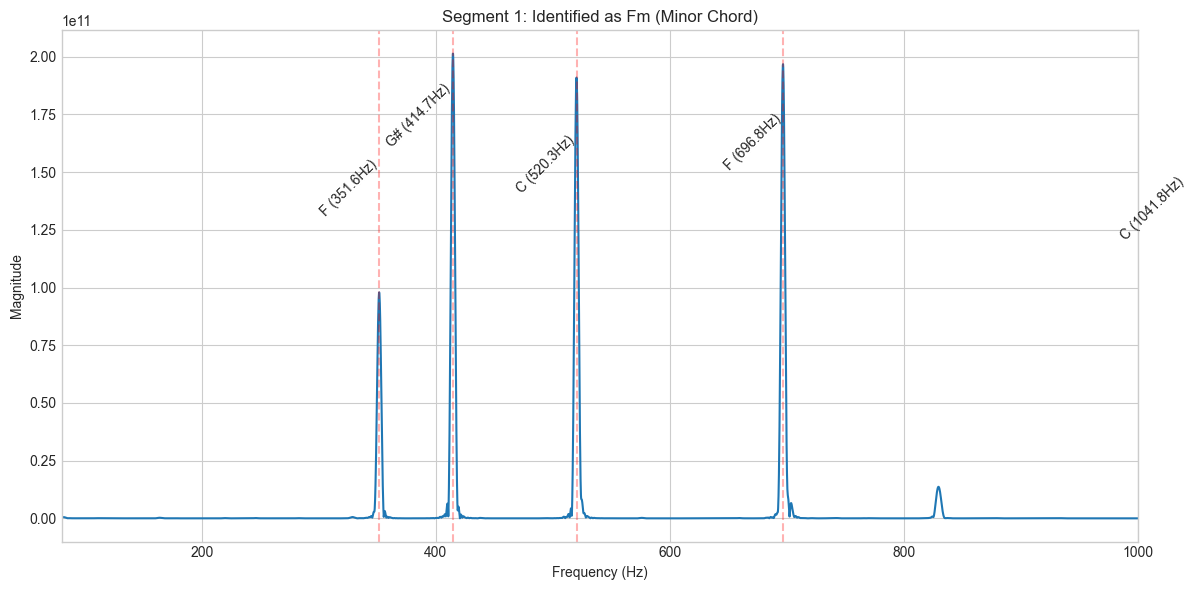

Segment 1 Analysis:
  Detected Notes: G#, F, C, F, C
  Chord Identification: Fm (Minor Chord)
  Chord Structure (1-3-5):
    1 (Root): F
    3 (Minor Third): G#
    5 (Perfect Fifth): C
  Top Frequencies: 414.7Hz, 696.8Hz, 520.3Hz, 351.6Hz, 1041.8Hz



In [54]:
# Analyze and visualize each segment
results = []

for i, segment in enumerate(chord_segments):
    # Get frequency peaks
    peak_freqs, peak_mags, all_freqs, spectrum = analyze_chord_frequencies(segment)
    
    # Convert top frequencies to notes
    detected_notes = []
    for freq in peak_freqs[:8]:  # Consider top 8 peaks
        note = frequency_to_note(freq)
        detected_notes.append(note)
    
    # Identify chord with detailed analysis
    chord_name, chord_type, chord_analysis = identify_chord(detected_notes)
    
    results.append({
        'segment_index': i,
        'detected_notes': detected_notes,
        'chord_name': chord_name,
        'chord_type': chord_type,
        'chord_analysis': chord_analysis,
        'peak_frequencies': peak_freqs,
        'peak_magnitudes': peak_mags,
        'spectrum': (all_freqs, spectrum)
    })
    
    # Visualize frequency spectrum for this segment
    plt.figure(figsize=(12, 6))
    plt.plot(all_freqs, spectrum)
    
    # Mark peak frequencies
    for j, freq in enumerate(peak_freqs[:8]):
        plt.axvline(x=freq, color='r', linestyle='--', alpha=0.3)
        note = frequency_to_note(freq)
        # Position text at different heights to avoid overlap
        plt.text(freq, spectrum.max() * (0.8 - j*0.05), 
                f"{note} ({freq:.1f}Hz)", 
                rotation=45, ha='right')
    
    # Expanded title with chord type
    if chord_type == 'major':
        chord_type_text = "Major"
    elif chord_type == 'minor':
        chord_type_text = "Minor"
    else:
        chord_type_text = "Unknown"
        
    plt.title(f"Segment {i+1}: Identified as {chord_name} ({chord_type_text} Chord)")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(80, 1000)  # Focus on guitar frequency range
    plt.tight_layout()
    plt.show()
    
    # Print detailed chord analysis
    print(f"Segment {i+1} Analysis:")
    print(f"  Detected Notes: {', '.join(detected_notes)}")
    print(f"  Chord Identification: {chord_name} ({chord_type_text} Chord)")
    
    # Print 1-3-5 chord structure
    if 'chord_tones' in chord_analysis:
        print("  Chord Structure (1-3-5):")
        for degree, note in sorted(chord_analysis['chord_tones'].items()):
            if degree == 1:
                print(f"    1 (Root): {note}")
            elif degree == 3:
                if chord_type == 'major':
                    print(f"    3 (Major Third): {note}")
                else:
                    print(f"    3 (Minor Third): {note}")
            elif degree == 5:
                print(f"    5 (Perfect Fifth): {note}")
    
    print(f"  Top Frequencies: {', '.join([f'{freq:.1f}Hz' for freq in peak_freqs[:5]])}")
    print()

### Visualization

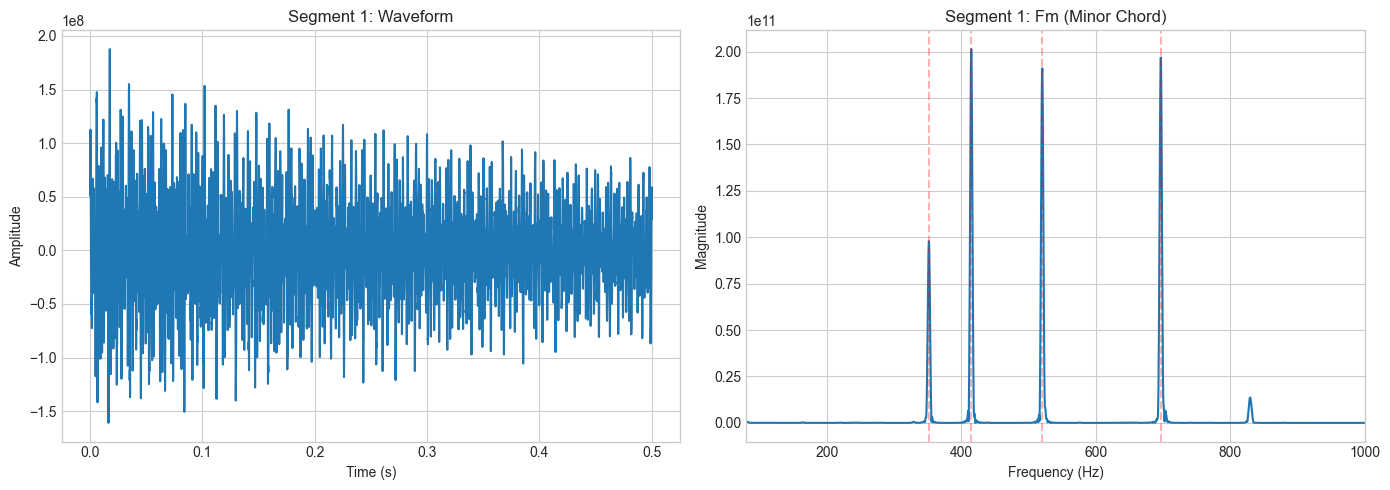


SUMMARY:
Segment 1: Fm (Minor Chord)
  Chord tones:
    1 (Root): F
    3 (Third): G#
    5 (Fifth): C
  Notes detected: G#, F, C, F, C



In [55]:
# Create a final visualization showing all segments and their identified chords
fig, axes = plt.subplots(len(chord_segments), 2, figsize=(14, 5*len(chord_segments)))

if len(chord_segments) == 1:  # Handle the case of a single segment
    axes = np.array([axes])

for i, result in enumerate(results):
    # Waveform display
    segment_samples = np.array(chord_segments[i].get_array_of_samples())
    segment_time = np.linspace(0, len(segment_samples) / chord_segments[i].frame_rate, len(segment_samples))
    
    axes[i, 0].plot(segment_time, segment_samples)
    axes[i, 0].set_title(f"Segment {i+1}: Waveform")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")
    
    # Spectrum display with identified chord
    all_freqs, spectrum = result['spectrum']
    axes[i, 1].plot(all_freqs, spectrum)
    
    # Mark peak frequencies
    for freq in result['peak_frequencies'][:5]:
        axes[i, 1].axvline(x=freq, color='r', linestyle='--', alpha=0.3)
    
    chord_type = "Major" if result['chord_type'] == 'major' else "Minor" if result['chord_type'] == 'minor' else "Unknown"
    axes[i, 1].set_title(f"Segment {i+1}: {result['chord_name']} ({chord_type} Chord)")
    axes[i, 1].set_xlabel("Frequency (Hz)")
    axes[i, 1].set_ylabel("Magnitude")
    axes[i, 1].set_xlim(80, 1000)

plt.tight_layout()
plt.show()

# Summary of results with chord types
print("\nSUMMARY:")
for result in results:
    chord_type = "Major" if result['chord_type'] == 'major' else "Minor" if result['chord_type'] == 'minor' else "Unknown"
    print(f"Segment {result['segment_index']+1}: {result['chord_name']} ({chord_type} Chord)")
    
    # Print chord structure
    if 'chord_analysis' in result and 'chord_tones' in result['chord_analysis']:
        chord_tones = result['chord_analysis']['chord_tones']
        print(f"  Chord tones:")
        for degree in sorted(chord_tones.keys()):
            degree_name = {1: "Root", 3: "Third", 5: "Fifth"}.get(degree, str(degree))
            print(f"    {degree} ({degree_name}): {chord_tones[degree]}")
    
    print(f"  Notes detected: {', '.join(result['detected_notes'])}")
    print()